In [0]:
import numpy as np
import pandas as pd
import gc
import sklearn.metrics
from fbprophet import Prophet

## Stuff below is to load the CSV's through google drive. Way too slow otherwise.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client. You'll need to do this in order to load the CSV files from drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
calendar_csv_drive_link = "https://drive.google.com/open?id=11FCINUYChtNJHRyY1mzbhaDWgVwlJzA9"
sales_train_validation_csv_drive_link = "https://drive.google.com/open?id=1CrJXm3TJBVoLwlG607kIFNCoxBPRem6C"
sample_submission_csv_drive_link = "https://drive.google.com/open?id=1F6ORVpIh5r-998HfGpv_jmitIQVc7d9j"
sell_prices_csv_drive_link = "https://drive.google.com/open?id=1BT-IveptPb3BjNcVt-sFWHabnrubwsGD"

calendar_id = calendar_csv_drive_link.split("=")[-1]
sales_train_val_id = sales_train_validation_csv_drive_link.split("=")[-1]
sample_submission_id = sample_submission_csv_drive_link.split("=")[-1]
sell_prices_id = sell_prices_csv_drive_link.split("=")[-1]

downloaded_calendar = drive.CreateFile({'id': calendar_id})
downloaded_calendar.GetContentFile('calendar.csv')

downloaded_sales_train = drive.CreateFile({'id': sales_train_val_id})
downloaded_sales_train.GetContentFile('sales_train_validation.csv')

downloaded_sales_train = drive.CreateFile({'id': sample_submission_id})
downloaded_sales_train.GetContentFile('sample_submission.csv')

downloaded_sales_train = drive.CreateFile({'id': sell_prices_id})
downloaded_sales_train.GetContentFile('sell_prices.csv')

Loading the data into DataFrames

In [4]:
sell_prices_df = pd.read_csv('sell_prices.csv')
sales_train_val_df = pd.read_csv('sales_train_validation.csv')
calendar_df = pd.read_csv('calendar.csv')
sell_prices_df.shape, sales_train_val_df.shape

((6841121, 4), (30490, 1919))

### Just taking a gander

In [5]:
sales_train_val_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [6]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [7]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


Checking out the dtypes - reducing the int64's to make it more memory efficient. Also filling in the NaN's with "unknown"

In [8]:

calendar_df[["month", "snap_CA", "snap_TX", "snap_WI", "wday"]] = \
calendar_df[["month", "snap_CA", "snap_TX", "snap_WI", "wday"]].astype("int8")
calendar_df[["wm_yr_wk", "year"]] = calendar_df[["wm_yr_wk", "year"]].astype("int16") 
calendar_df["date"] = calendar_df["date"].astype("datetime64")

nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features:
    calendar_df[feature].fillna('unknown', inplace = True)
    
print(calendar_df.dtypes)

date            datetime64[ns]
wm_yr_wk                 int16
weekday                 object
wday                      int8
month                     int8
year                     int16
d                       object
event_name_1            object
event_type_1            object
event_name_2            object
event_type_2            object
snap_CA                   int8
snap_TX                   int8
snap_WI                   int8
dtype: object


Seeing what events there are. Not sure how we should encode these but it looks small enough to me to have one hot... looks like it's going to be hella one hot encoding though?

In [9]:
print(calendar_df.event_name_1.unique())
print(calendar_df.event_name_2.unique())

['unknown' 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart'
 'LentWeek2' 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End'
 'Cinco De Mayo' "Mother's day" 'MemorialDay' 'NBAFinalsStart'
 'NBAFinalsEnd' "Father's day" 'IndependenceDay' 'Ramadan starts'
 'Eid al-Fitr' 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha'
 'VeteransDay' 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear'
 'OrthodoxChristmas' 'MartinLutherKingDay' 'Easter']
['unknown' 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


Ok so if we are going the route of combining the dataframes into one then that should be enough for the calendar for now. Let's look at sales_train_validation

In [10]:
sales_train_val_df.dtypes #welp that's a lot of  columns. good idea to make it smaller to take up less memory probably

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object

In [0]:
# Turning them into int16's. 
sales_train_val_df.loc[:, "d_1":] = sales_train_val_df.loc[:, "d_1":].astype('int16')

In [12]:
sales_train_val_df.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int16
d_1910       int16
d_1911       int16
d_1912       int16
d_1913       int16
Length: 1919, dtype: object

In [13]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [0]:
# Make ID column to sell_price dataframe
sell_prices_df.loc[:, "id"] = sell_prices_df.loc[:, "item_id"] + "_" + sell_prices_df.loc[:, "store_id"] + "_validation"

In [15]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price,id
0,CA_1,HOBBIES_1_001,11325,9.58,HOBBIES_1_001_CA_1_validation
1,CA_1,HOBBIES_1_001,11326,9.58,HOBBIES_1_001_CA_1_validation
2,CA_1,HOBBIES_1_001,11327,8.26,HOBBIES_1_001_CA_1_validation
3,CA_1,HOBBIES_1_001,11328,8.26,HOBBIES_1_001_CA_1_validation
4,CA_1,HOBBIES_1_001,11329,8.26,HOBBIES_1_001_CA_1_validation


In [0]:
def make_dataframe():
    # Wide format dataset 
    df_wide_train = sales_train_val_df.drop(columns=["item_id", "dept_id", "cat_id", "state_id","store_id", "id"]).T
    df_wide_train.index = calendar_df["date"][:1913]
    df_wide_train.columns = sales_train_val_df["id"]
    
    # Making test label dataset
    df_wide_test = pd.DataFrame(np.zeros(shape=(56, len(df_wide_train.columns))), index=calendar_df.date[1913:], columns=df_wide_train.columns)
    df_wide = pd.concat([df_wide_train, df_wide_test])

    # Convert wide format to long format
    df_long = df_wide.stack().reset_index(1)
    df_long.columns = ["id", "value"]

    del df_wide_train, df_wide_test, df_wide
    gc.collect()
    
    df = pd.merge(pd.merge(df_long.reset_index(), calendar_df, on="date"), sell_prices_df, on=["id", "wm_yr_wk"])
    df = df.drop(columns=["d"])
#     df[["cat_id", "store_id", "item_id", "id", "dept_id"]] = df[["cat_id"", store_id", "item_id", "id", "dept_id"]].astype("category")
    df["sell_price"] = df["sell_price"].astype("float16")   
    df["value"] = df["value"].astype("int32")
    df["state_id"] = df["store_id"].str[:2].astype("category")


    del df_long
    gc.collect()

    return df

df = make_dataframe()

In [0]:
TEST_ID = "HOBBIES_1_008_CA_1_validation"

### Just checking out what it looks like before. Chopping off the end in order to calculate error.

In [35]:
practice_df = df[df.id == TEST_ID].rename(columns={
    'date': 'ds',
    "value": "y"
})[["ds", "y"]]


practice_df_train = practice_df[:-365]
practice_df_val = practice_df[-365:]
print(f"practice_df_train shape: {practice_df_train.shape}")
print(f"practice_df_val shape: {practice_df_val.shape}")

practice_df_train shape: (1604, 2)
practice_df_val shape: (365, 2)


WRMSSE formula. Currently initializing weights to None. fuckin child's play

In [0]:
def WRMSSE(y_true,y_pred,weights=None):
  RMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_true,y_pred))
  if weights:
    return np.multiply(weights, RMSE)
  return RMSE



Let's try predicting this with prophet and see how we do.

In [38]:
m = Prophet()
m.fit(practice_df_train)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
predictions = forecast['yhat']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Alright we got the predictions. Let's see how we did.

In [44]:
future_predictions = predictions[-365:]
error = WRMSSE(practice_df_val['y'],future_predictions)
print(error)

11.344989389681675


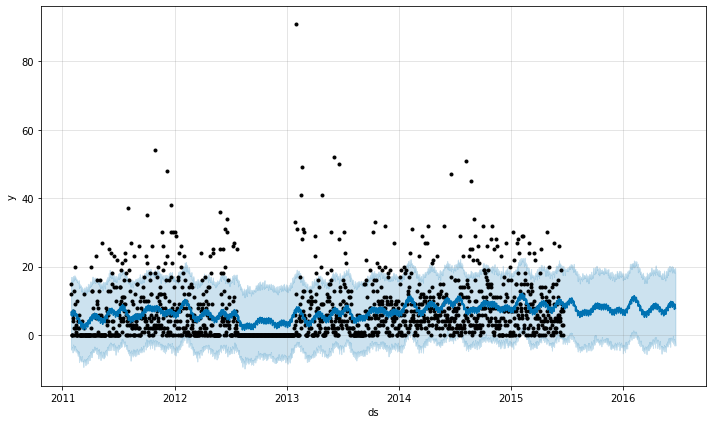

In [45]:
fig1 = m.plot(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


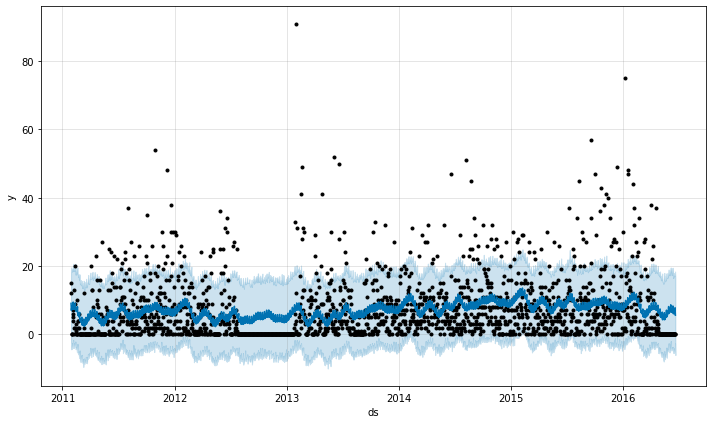

In [51]:
new_m = Prophet()
new_m.fit(practice_df)
correct_forecast = new_m.predict(practice_df)
fig2 = new_m.plot(correct_forecast)